In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


In [308]:
train_file_path="/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
test_file_path="/kaggle/input/house-prices-advanced-regression-techniques/test.csv"
train=pd.read_csv(train_file_path)
test=pd.read_csv(test_file_path)

In [309]:
train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [310]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [311]:
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
MSZoning,0,4.0
LotFrontage,259,227.0
Alley,1369,1352.0
Utilities,0,2.0
Exterior1st,0,1.0
Exterior2nd,0,1.0
MasVnrType,872,894.0
MasVnrArea,8,15.0
BsmtQual,37,44.0
BsmtCond,37,45.0


In [312]:
test_ids = test['Id']

In [313]:
dfs=[train,test]

In [314]:
# List of columns to drop
columns_to_drop = ['Id','Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
                   'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
                   'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature',
                   'MiscVal','Alley','FireplaceQu','MasVnrType']

# Drop columns from each DataFrame in the list
dfs = [df.drop(columns=columns_to_drop, axis=1) for df in dfs]

In [315]:
def fill_missing_values(df):
    # Fill missing numerical values with median
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

    # Fill specific categorical columns with 'None' (indicating absence)
    none_fill_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                      'GarageType', 'GarageFinish', 'GarageQual']
    for col in none_fill_cols:
        if col in df.columns:
            df[col].fillna("None", inplace=True)

    # Fill 'Electrical' with mode
    if 'Electrical' in df.columns:
        df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)

    # Fill remaining categorical columns with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

    return df

In [316]:
dfs = [fill_missing_values(df) for df in dfs]

<ipython-input-315-5b86aa1ebb1d>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("None", inplace=True)
<ipython-input-315-5b86aa1ebb1d>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [317]:
nominal_features = [
    'MSZoning', 'Street', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
    'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 
    'GarageType', 'SaleType', 'SaleCondition', 'LandContour','LotConfig', 'BsmtFinType1', 'BsmtFinType2'
]



# List of ordinal categorical features (Label Encoding)
ordinal_features = {
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'PavedDrive': ['N', 'P', 'Y'],
    'LotShape' : ['Reg', 'IR1' , 'IR2' , 'IR3'],
    'LandSlope' : ['Gtl', 'Mod', 'Sev'],
    'CentralAir' : ['N' , 'Y'],
    'Electrical' : ['SBrkr' ,  'FuseA' , 'FuseF' , 'FuseP' , 'Mix']
    
}



In [318]:
for i in range(len(dfs)):
    # One-Hot Encoding
    dfs[i] = pd.get_dummies(dfs[i], columns=nominal_features, drop_first=True)

    # Label Encoding
    for col, categories in ordinal_features.items():
        dfs[i][col] = dfs[i][col].apply(lambda x: categories.index(x))

In [319]:
train , test = dfs

In [320]:
# objects = train.select_dtypes(include=['object'])
# print(objects)

<Axes: >

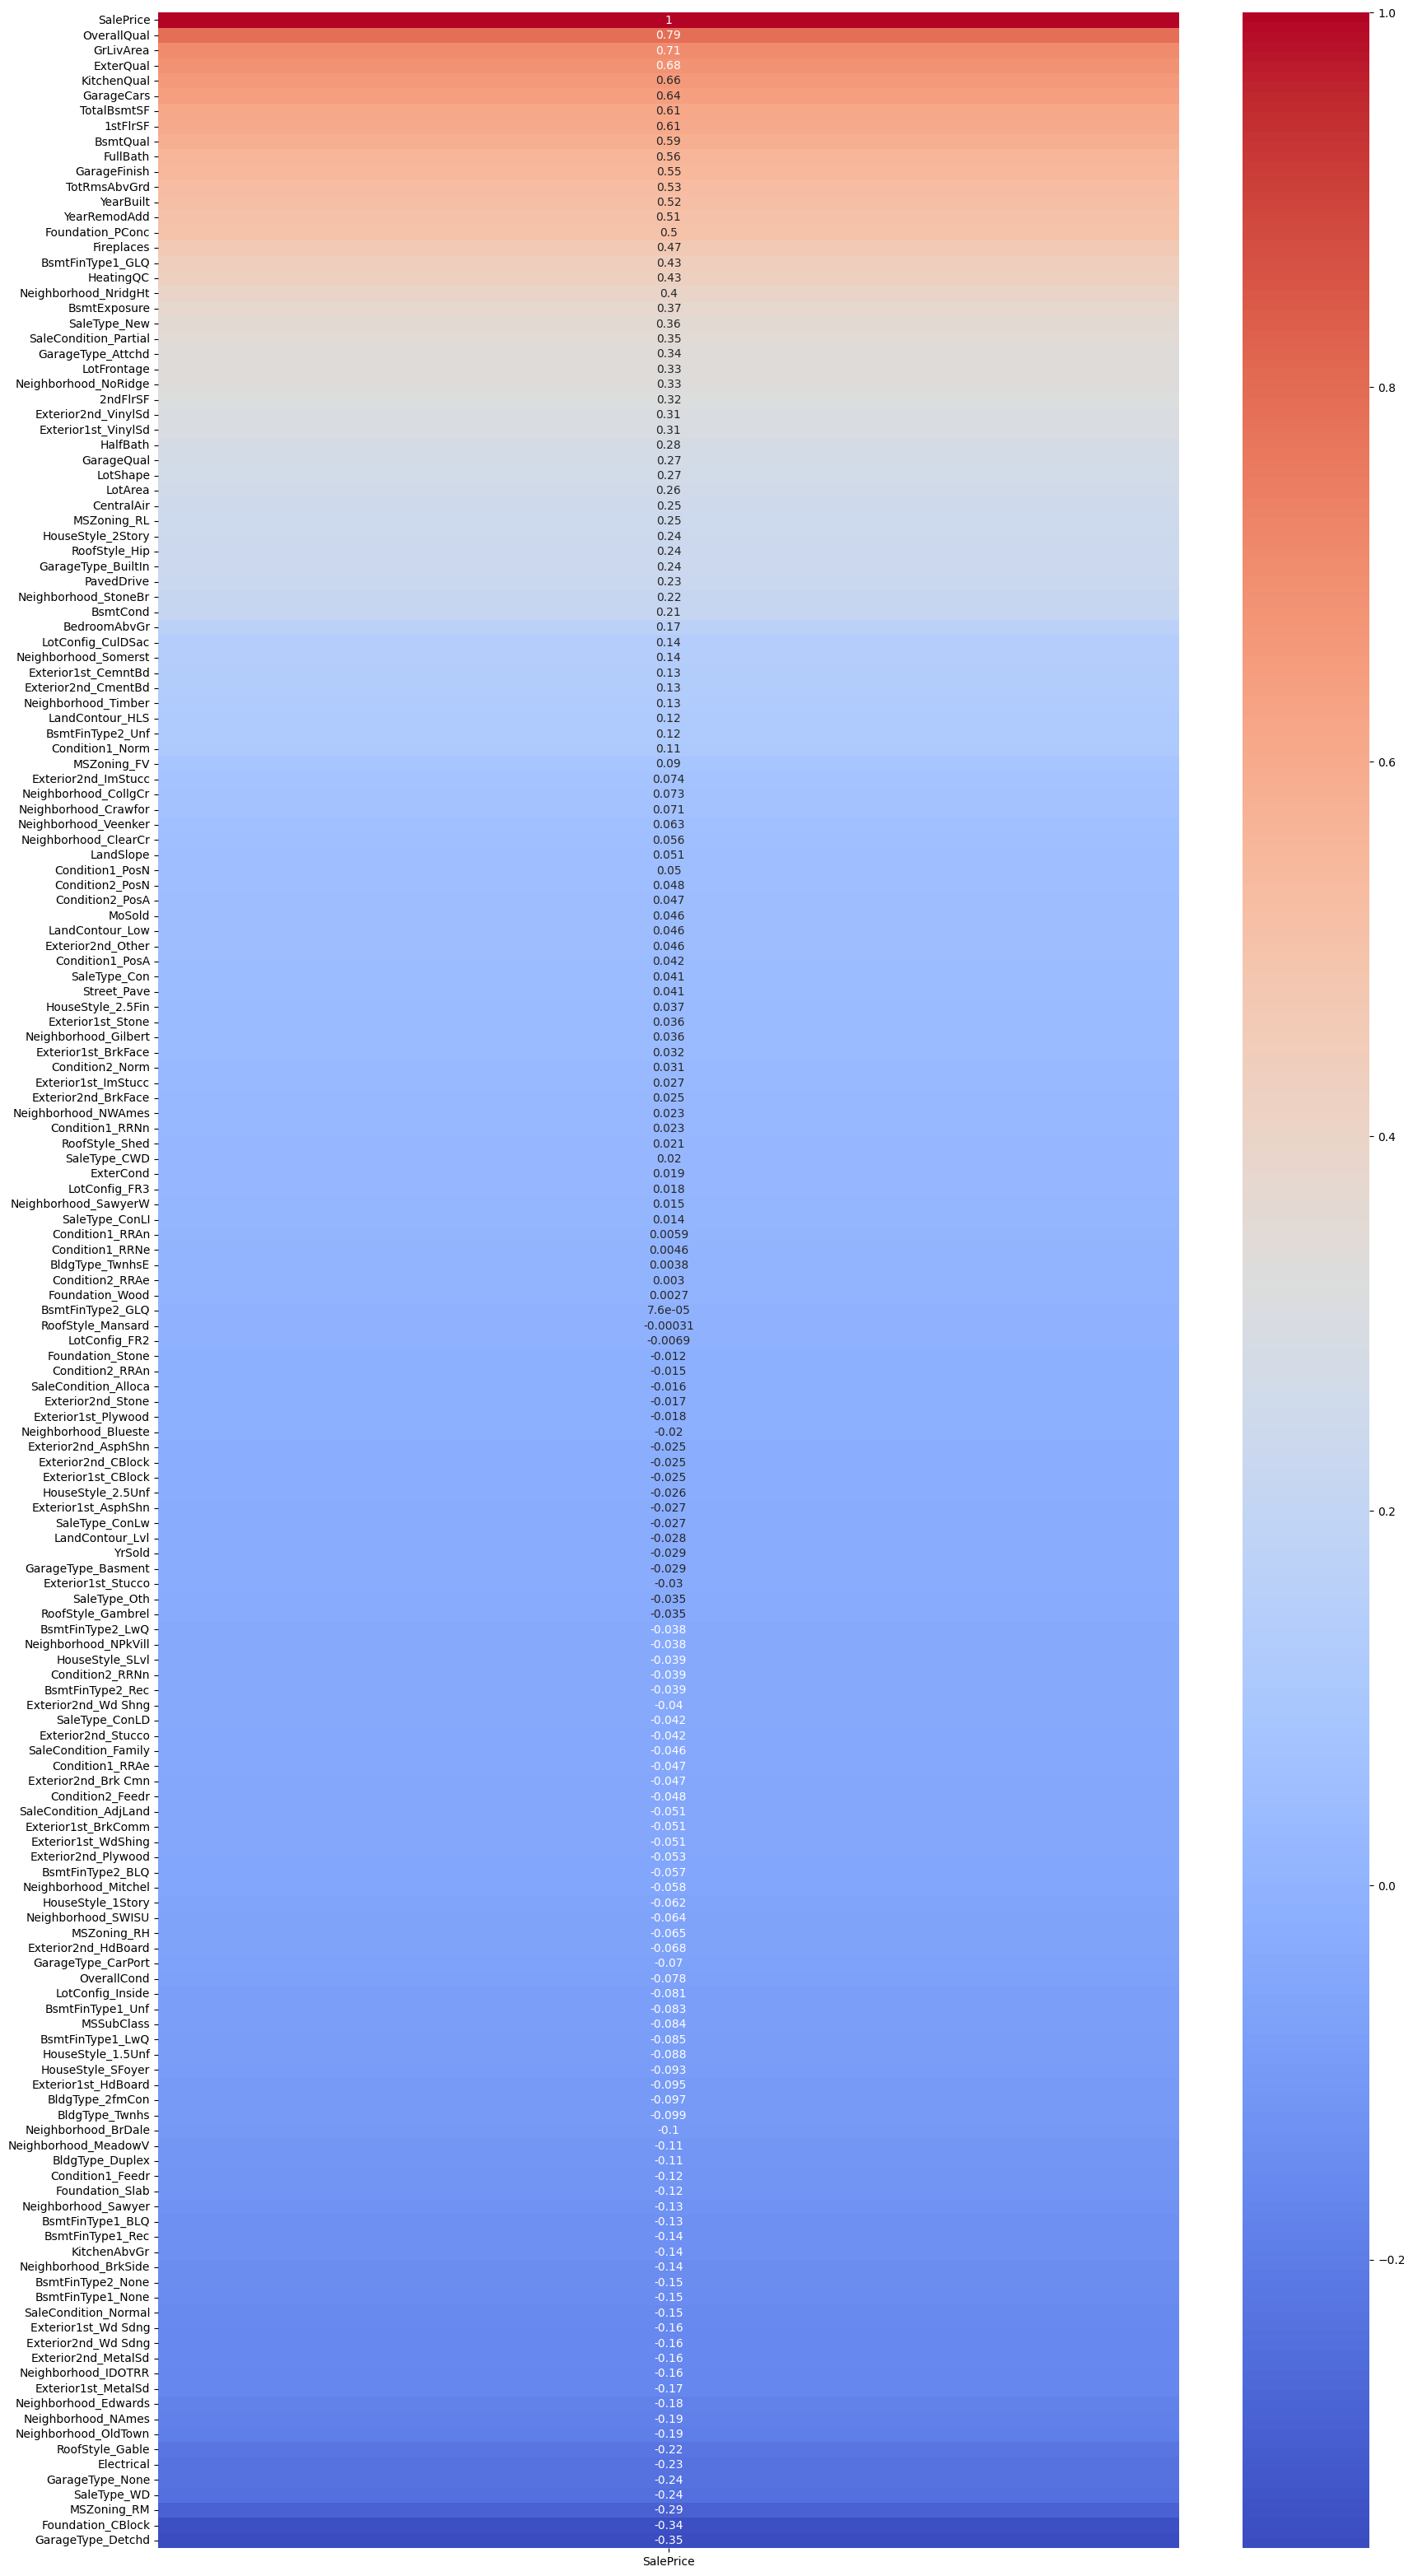

In [321]:
corr = train.corr()
plt.figure(figsize=(20,40))
sns.heatmap(corr[['SalePrice']].sort_values(by='SalePrice', ascending=False), cmap="coolwarm", annot=True)

In [322]:
threshold = 0.6  # Set the correlation threshold
correlation_with_price = train.corr()['SalePrice'].sort_values(ascending=False)

# Select features with correlation above the threshold (excluding SalePrice itself)
selected_features = correlation_with_price[correlation_with_price > threshold].index.tolist()

# Display selected features
print("Selected Features:", selected_features)


Selected Features: ['SalePrice', 'OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']


In [323]:
selected_features.remove('SalePrice')
X = train[selected_features]  # Features for training
y = train['SalePrice']        # Target variable

X_test = test[selected_features]    # Features for test (without SalePrice)

print("Filtered Train Shape:", X.shape)
print("Filtered Test Shape:", X_test.shape)

Filtered Train Shape: (1460, 7)
Filtered Test Shape: (1459, 7)


In [324]:
# Split into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [327]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),  
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=100, batch_size=64, verbose=1)

y_pred = model.predict(X_test)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 175492.7500 - val_loss: 176249.7812
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 176673.4844 - val_loss: 166380.5469
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 166322.6406 - val_loss: 124166.1484
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 101142.2656 - val_loss: 36889.3359
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43035.4336 - val_loss: 37410.5352
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38947.7617 - val_loss: 35135.8594
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37733.6914 - val_loss: 35254.7461
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38604.4102 - val_loss: 34763.5898
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37162.1172 - val_loss: 34856.4570
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36307.8867 - val_loss: 34441.3867
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3

In [328]:
y_pred = y_pred.flatten()

In [329]:
# Save results
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': y_pred})
submission.to_csv('submission.csv', index=False)

print("Predictions saved to submission.csv")


Predictions saved to submission.csv
